In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import nnls
import seaborn as sns
#from sklearn.linear_model import LinearRegression

# Smarter model, paper model

In [2]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["SystemCpuUsage"] + 1)#*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [3]:
def load_df_list_train():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112","results_1500/results_dgemm",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                    
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[10:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_list_test():
    directory_list=["results_1500/results_32","results_1500/results_64",
                    "results_1500/results_96","results_1500/results_16","results_1500/results_48","results_1500/results_80",
                    "results_1500/results_112",
                    "results_1500/results_128","results_1500/results_sleep","results_1500/results_fan","results_1500/results_dgemm"]
    #directory_list=["results_1500/results_fan"]

    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    
                    if ("dgemm" not in directory) and ("simple" not in directory) and ("sleep" not in directory)and ("fan" not in directory) and (filename.find("_") > 0) and (filename.find(".") > 0):
                        bench_name=filename[filename.find("_")+1:filename.find(".")]
                    elif "dgemm" in directory:
                        bench_name="dgemm"
                    elif "simple" in directory:
                        bench_name="simple"
                    elif "sleep" in directory:
                        bench_name="sleep"
                        
                    if "sleep" in directory:
                        cores=0
                    elif "fan" in directory:
                        cores=1
                    elif "dgemm" in directory:
                        cores=int(filename[6:filename.find(".")])
                    elif "simple" in directory:
                        cores=int(filename[6:filename.find(".")])
                    else:
                        cores=int(directory.split("_")[2])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[10:30])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list


In [4]:
df_list_train= load_df_list_train()
df = pd.concat([ i  for i in df_list_train if i is not None])

In [5]:
df["name"].unique()

array(['peakflops_avx_fma', 'store_mem', 'load_mem', 'copy_mem_avx',
       'store_mem_avx', 'copy', 'copy_mem', 'daxpy_mem_avx_fma',
       'update_avx', 'stream_mem_avx_fma', 'load_avx', 'dgemm', 'sleep'],
      dtype=object)

In [6]:
independent_variables=[ "ProbabilityScalarArithmetic",
                        	"ProbabilityScalarMemory", "ProbabilityScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

In [7]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 765.1122210232646, intercept 345.9386384990855
ProbabilityScalarArithmetic 17.381239713880387
ProbabilityScalarMemory 24.379172324778065
ProbabilityScalarLogic 0.0
ProbabilityVectorArithmetic 18.363833304210537
ProbabilityVectorLogic 142.30650450923721
ProbabilityVectorMemory 24.39839474599216


In [8]:
def assign_colors(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    color_map = plt.get_cmap('tab20')  # You can change the color map here

    label_to_color = {}
    for i, label in enumerate(unique_labels):
        label_to_color[label] = color_map(i / num_labels)

    return label_to_color
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors

{'copy': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'copy_mem': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), 'copy_mem_avx': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), 'daxpy_mem_avx_fma': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'dgemm': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'load_avx': (1.0, 0.596078431372549, 0.5882352941176471, 1.0), 'load_mem': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0), 'peakflops_avx_fma': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'sleep': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'store_mem': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0), 'store_mem_avx': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0), 'stream_mem_avx_fma': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 'update_avx': (0.09019607843137255, 0.74509803

(345.0, 625.0)

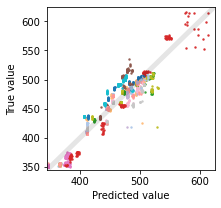

In [9]:
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(3,3))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], '.', 
                 markersize=3, 
                 alpha=0.8,
                 fillstyle='full',
                 #markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([345,625])
plt.ylim([345,625])

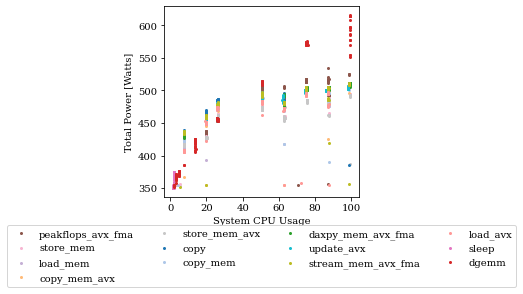

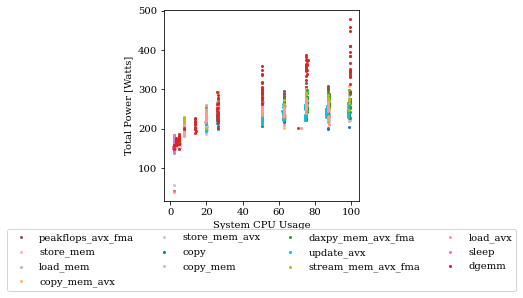

In [10]:
plt.rcParams["font.family"] = "DeJavu Serif"


df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df["total_socket"]=df["SocketPower0"]+df["SocketPower1"]
#df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_socket"] > 200) | (df["total_power"] > 400)]
column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']

for source in ['total_power', 'total_socket']:
    plt.figure(figsize=(3.5,3.5))
    color=[name_to_color[i] for i in df["name"]]

    for _,row in df.iterrows():
        plt.scatter(row["SystemCpuUsage"],row[source],s=4,label=row["name"], color=name_to_color[row["name"]])

    plt.ylabel("Total Power [Watts]")
    plt.xlabel("System CPU Usage")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(),ncol=2,handleheight=2.4, labelspacing=0.05)
    #plt.legend(by_label.values(), by_label.keys())
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=4, loc="lower center")
    plt.savefig(f"{source}.pdf", bbox_inches="tight")

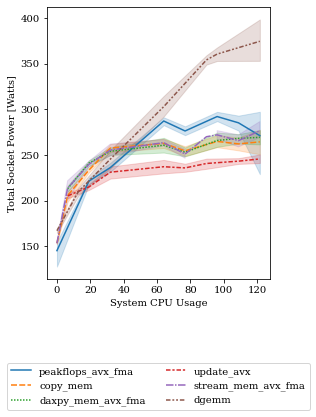

In [100]:
plt.rcParams["font.family"] = "DeJavu Serif"


df_list_test= load_df_list_test()
df=pd.concat(df_list_test)
df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df["total_socket"]=df["SocketPower0"]+df["SocketPower1"]
#df["total_power"]=df["PSUPower0"]+df["PSUPower1"]
df=df[ (df["SystemCpuUsage"] < 7) | (df["total_socket"] > 250) | (df["total_power"] > 400)]
column_name_probability = ['ProbabilityScalarArithmetic',
        'ProbabilityScalarLogic',
        'ProbabilityScalarMemory',
        'ProbabilityScalarBranch',
        'ProbabilityScalarJump',
        'ProbabilityVectorArithmetic',
        'ProbabilityVectorLogic',
        'ProbabilityVectorMemory',
        'ProbabilityVectorBranch',
        'ProbabilityVectorJump']

tests=["peakflops_avx_fma", "daxpy_mem_avx_fma", "dgemm", "update_avx", "copy_mem", "stream_mem_avx_fma"]
frame = pd.DataFrame()
for source in ['total_socket']:
    plt.figure(figsize=(4,5))
    color=[name_to_color[i] for i in df["name"]]
    dfn = df[df["name"].isin(tests)]
    dfn["usage"] = (dfn["SystemCpuUsage"] - (dfn["SystemCpuUsage"] % 5)) * 1.28
    sns.lineplot(data=dfn, x="usage", y=source, hue="name", style="name")
    #for _,row in df.iterrows():
    #    print(row.head())
        #if (row["name"] in ["peakflops_avx_fma", "daxpy_mem_avx_fma","dgemm"]):
        #    sns.lineplot(data=row, x="SystemCpuUsage", y=source, hue=row["name"])
            #plt.scatter(row["SystemCpuUsage"],row[source],s=4,label=row["name"], color=name_to_color[row["name"]])

    plt.ylabel("Total Socket Power [Watts]")
    plt.xlabel("System CPU Usage")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(),ncol=1,handleheight=2.4, labelspacing=0.05)
    #plt.legend(by_label.values(), by_label.keys())
    plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=2, loc="lower center")
    plt.savefig(f"{source}-filled.pdf", bbox_inches="tight")

matplotlib.__version__

36
[25, 45, 65, 85, 105, 125]


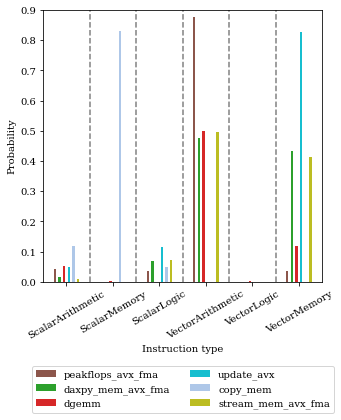

In [95]:
plt.rcParams["font.family"] = "DeJavu Serif"
cores=16
independent_variables=[ "ProbabilityScalarArithmetic",
                        	"ProbabilityScalarMemory", "ProbabilityScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

column_name_probability_labels=[ "ScalarArithmetic",
                        	"ScalarMemory", "ScalarLogic",
                       #"ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "VectorArithmetic", 	"VectorLogic",
                       "VectorMemory", 	]#"ProbabilityVectorBranch",
                      # "ProbabilityVectorJump"]#,"SocketPower0","SocketPower1"]

tests=["peakflops_avx_fma", "daxpy_mem_avx_fma", "dgemm", "update_avx", "copy_mem", "stream_mem_avx_fma"]

df_list_test= load_df_list_train()
df=pd.concat(df_list_test)

jitter=np.array([i/len(tests) for i in range(0,len(tests))])
plt.figure(figsize=(5,5))
offset=0
ticks=list()
for var in independent_variables:
    y=list()
    offset+=20
    for test in tests:
        y.append(df[(df["cores"]==32) & (df["name"]==test)][var].mean()/100)
    plt.bar(jitter*12+offset,y,width=1.0,label=tests,color=[name_to_color[t] for t in tests])   
    ticks.append(offset+5)

handles, labels = plt.gca().get_legend_handles_labels()
print(len(handles))
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(0.5, -0.5),ncol=2, loc="lower center")
print(ticks)
plt.xticks(ticks=ticks, labels=column_name_probability_labels,rotation=30)
plt.xlabel("Instruction type")
plt.ylabel("Probability")
plt.xlim([15, 135])
plt.ylim([0, 0.9])

for i in range(len(ticks) - 1):
    plt.vlines(ticks[i] + 10, ymin=0, ymax=0.9, colors='gray', linestyles='dashed')
plt.savefig("histogram.pdf", bbox_inches='tight')

In [24]:
df_tmp=df[df["name"]=="dgemm"].copy()

In [25]:
df_tmp[independent_variables].mean()/100

ProbabilityScalarArithmetic    0.052839
ProbabilityScalarMemory        0.004029
ProbabilityScalarLogic         0.002649
ProbabilityVectorArithmetic    0.510796
ProbabilityVectorLogic         0.003750
ProbabilityVectorMemory        0.120059
dtype: float64

In [26]:
def normalize_model1(df):
    percentages=independent_variables=["ProbabilityScalarArithmetic",
                       "ProbabilityScalarLogic", 	"ProbabilityScalarMemory",
                       "ProbabilityScalarBranch", 	"ProbabilityScalarJump",
                       "ProbabilityVectorArithmetic", 	"ProbabilityVectorLogic",
                       "ProbabilityVectorMemory", 	"ProbabilityVectorBranch",
                       "ProbabilityVectorJump"]
    
    df[percentages]=df[percentages]/100
    Pidle = 351
    df["SystemCpuUsage"]=df["SystemCpuUsage"]*128/100
    df["ProcessCpuUsage"]=df["ProcessCpuUsage"]*128/100
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"] 
    df["Total_socket"]=df["SocketPower0"]+df["SocketPower1"] 
    TDP=280

    for var in independent_variables:
  #      df[var]=df[var]*df["SystemCpuUsage"]*TDP*2
        df[var]=np.log(df[var]*df["ProcessCpuUsage"] + 1) #*df["Total_socket"]
        
    df = df[ (df["SocketPower0"] > 0) & (df["SocketPower1"] > 0) ]
        
    return df


In [27]:
def load_df_list_train_noise():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
def load_df_list_test():
    directory_list=["results_1500/results_no_noise","results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    df_list.append(df)
                    #df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
    

In [28]:
df_list_train= load_df_list_train()
df = pd.concat(df_list_train)
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
#df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
df = normalize_model1(df.copy())

A=df[independent_variables].to_numpy()

b=np.ones((A.shape[0],1))

A=np.hstack((A,b))

coeff_1,error_1=nnls(A, df["Total_power"].to_numpy(), maxiter=1000)
intercept_1=coeff_1[-1]
print(f"Residual {error_1}, intercept {intercept_1}")
#print(coeff)

for name,value in zip(independent_variables,coeff_1):
    print(name,value)

Residual 1007.6856888325165, intercept 353.3886553080839
ProbabilityScalarArithmetic 13.351666843501091
ProbabilityScalarMemory 23.988412716174278
ProbabilityScalarLogic 0.0
ProbabilityVectorArithmetic 16.80911587811535
ProbabilityVectorLogic 170.8737397393976
ProbabilityVectorMemory 24.38828633127049


{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

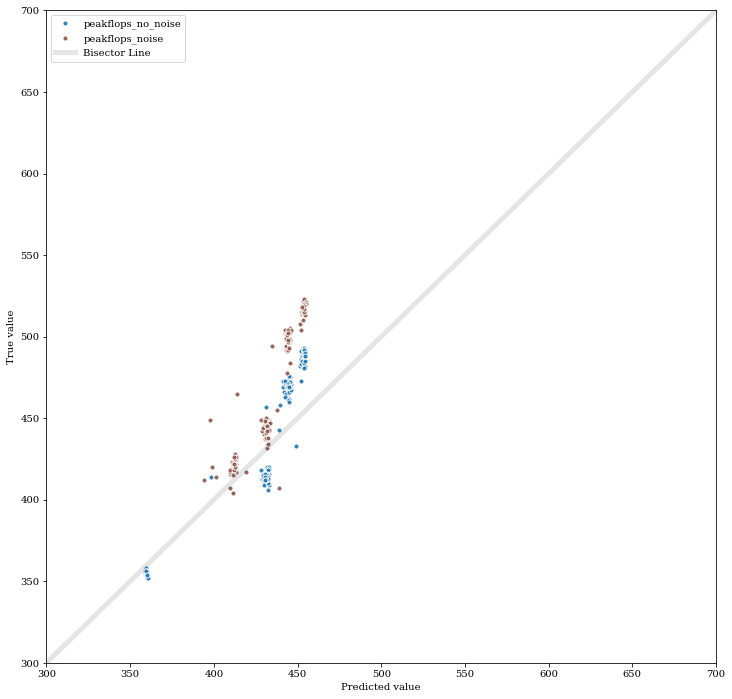

In [29]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                 markersize=5, 
                 alpha=0.9,
                 fillstyle='full',
                 markeredgecolor='white',
                 markeredgewidth=1,label=test_name,color=name_to_color[test_name])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

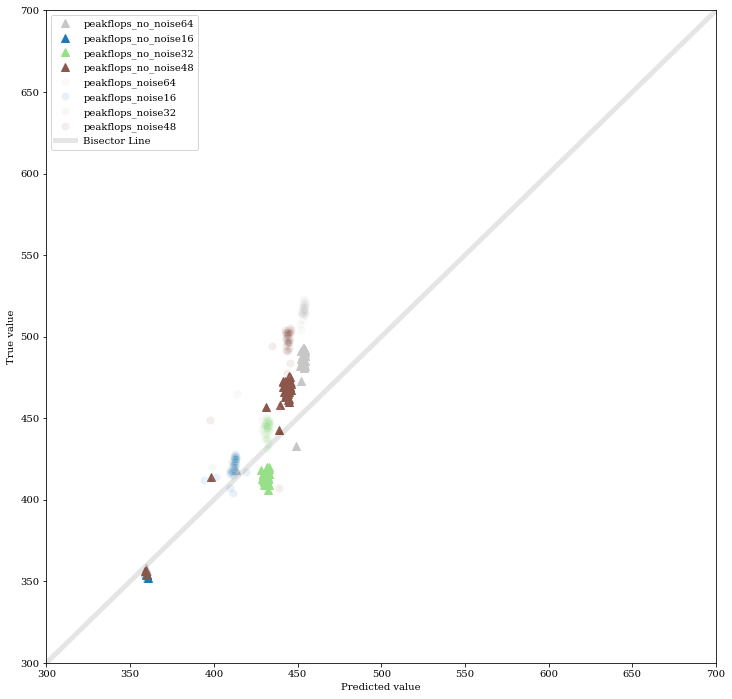

In [30]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        if test_name=="peakflops_no_noise":
            pass
            plt.plot(df1["prediction"],df1["Total_power"], '^', 
                     markersize=8, 
                     alpha=1.0,
                     fillstyle='full',
#                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])
        
        if test_name=="peakflops_noise":
            plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                     markersize=8, 
                     alpha=0.1,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name+f"{cores}",color=cores_to_color[cores])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


(300.0, 700.0)

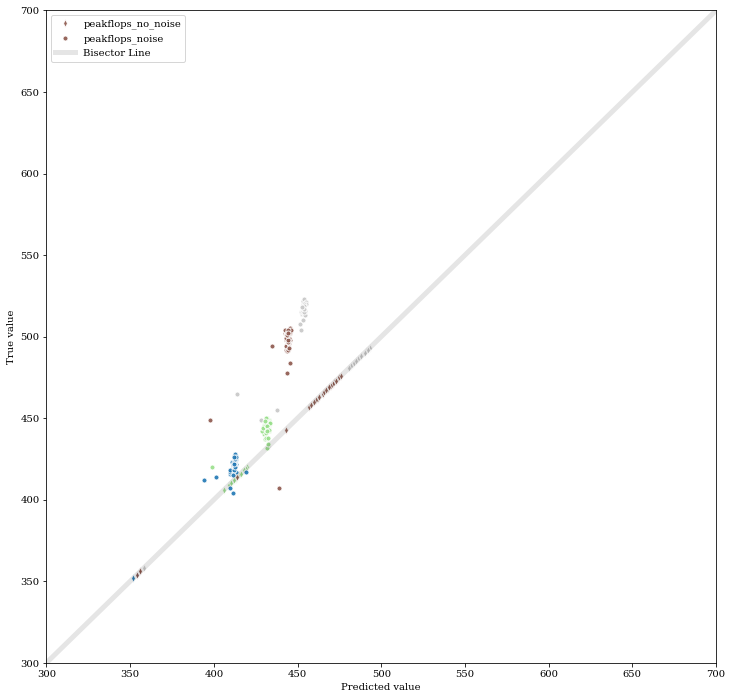

In [31]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,12))

for df in df_list_test:
#df = pd.concat(df_list_test)
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]

    #df1=df[ (df["SystemCpuUsage"] < 40) | (df["Total_power"] > 425)].copy()
    df1 = normalize_model1(df.copy())
    prediction=list()
    if True:
        for row in df1[independent_variables].to_numpy():
            #print(row)
            prediction.append(row@coeff_1[:-1] + intercept_1)
        df1["prediction"]=prediction
        if len(df) <1:
            continue
        test_name=df1["name"].iloc[0]
        cores=df1["cores"].iloc[0]
        if test_name=="peakflops_no_noise":
            pass
            plt.plot(df1["Total_power"],df1["Total_power"], 'd', 
                     markersize=5, 
                     alpha=0.9,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name,color=cores_to_color[cores])
        
        if test_name=="peakflops_noise":
            pass
            plt.plot(df1["prediction"],df1["Total_power"], 'o', 
                     markersize=5, 
                     alpha=0.9,
                     fillstyle='full',
                     markeredgecolor='white',
                     markeredgewidth=1,label=test_name,color=cores_to_color[cores])

plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([300,700])
plt.ylim([300,700])

{'peakflops_no_noise': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'peakflops_noise': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)}


Text(0.5, 0, 'experiment')

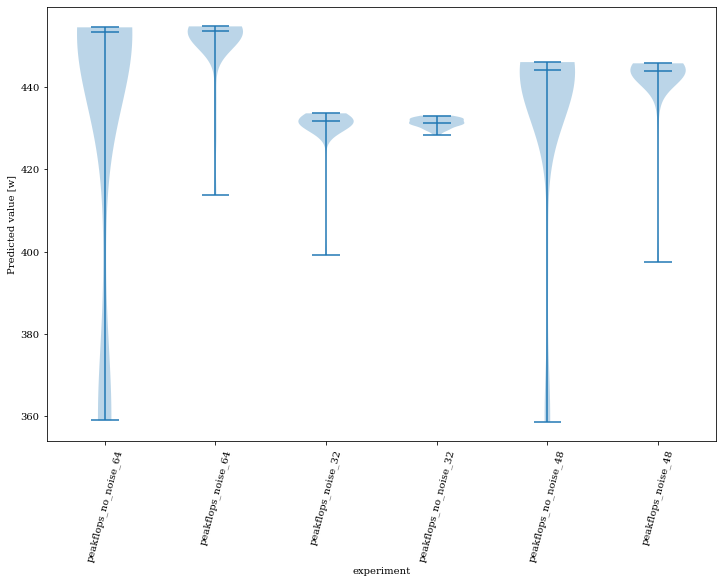

In [32]:
df= load_df_list_test()
df = pd.concat(df)
# Example usage:
cores_to_color = assign_colors(df["cores"])
name_to_color = assign_colors(df["name"])

print(name_to_color)  # This will print the mapping of labels to colors
import warnings
warnings.filterwarnings('ignore')

df_list_test= load_df_list_test()
plt.figure(figsize=(12,8))

columns=list()
columns_labels=list()
for df in df_list_test:
    
    df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
    df=df[ (df["SystemCpuUsage"] < 7) | (df["Total_power"] > 400)]
    df1 = normalize_model1(df.copy())
    if len(df) <1:
        continue
    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    if cores==8 or cores==16:
        continue
    prediction=list()
    
    for row in df1[independent_variables].to_numpy():
        prediction.append(row@coeff_1[:-1] + intercept_1)
    df1["prediction"]=prediction

    test_name=df1["name"].iloc[0]
    cores=df1["cores"].iloc[0]
    
    columns.append(df1["prediction"])
    columns_labels.append(test_name+f"_{cores}")
    
#    if test_name=="peakflops_no_noise":
#        plt.violinplot(df1["prediction"])
        
#    if test_name=="peakflops_noise":
#        plt.violin(df1["prediction"])
#for i in range(len(columns)/2):
columns[1],columns[3]=columns[3],columns[1]
columns_labels[1],columns_labels[3]=columns_labels[3],columns_labels[1]

columns[2],columns[4]=columns[4],columns[2]
columns_labels[2],columns_labels[4]=columns_labels[4],columns_labels[2]

violin_parts = plt.violinplot(columns, showmedians=True)
plt.xticks([y + 1 for y in range(len(columns))],
                  labels=columns_labels,rotation=90-15)


#plt.plot([0,700],[0,700], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.ylabel("Predicted value [w]")
plt.xlabel("experiment")
#plt.xlim([300,700])
#plt.ylim([300,700])

In [21]:
def load_df_noise():
    directory_list=["results_1500/results_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list
    
def load_df_no_noise():
    directory_list=["results_1500/results_no_noise"]

    #directory_list=["results_1500/results_32"]
    df_list=list()
    for directory in directory_list:
        for filename in os.listdir(directory):
            if filename.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(directory, filename))
                    if "no_noise" in directory:
                        bench_name="peakflops_no_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    else:
                        bench_name="peakflops_noise"
                        cores=int(filename.split("_")[1].split(".")[0])
                    #df["name"]=directory+filename[]
                    df["name"]=bench_name
                    df["cores"]=cores
                    #df_list.append(df)
                    df_list.append(df.iloc[2:20])
                    #print(type(df_list[-1]))
                    #print(f"Opened file: {filename}")
                    #print(df.head())  # prints the first 5 rows of each CSV file
                    #plot(df,os.path.basename(filename).split(".")[0])
                except Exception as e:
                    print(e)
    return df_list

In [22]:
Pstatic=345.9
Cores=16

In [23]:
df=pd.concat(load_df_noise())

In [24]:
df=df[df["cores"]==Cores]

In [25]:
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
print(f"E[total-static] {df["Total_power"].mean()-Pstatic}")

SyntaxError: invalid syntax (<ipython-input-25-291ed46265a3>, line 2)

In [ ]:
df=pd.concat(load_df_no_noise())
df=df[df["cores"]==Cores]
df["Total_power"]=df["PSUPower0"]+df["PSUPower1"]
print(f"E[total-static] {df["Total_power"].mean()-Pstatic}")